In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, recall_score, accuracy_score
from scipy import stats
from Bio import SeqIO
from adopt.utils import fasta_to_df, df_to_fasta
import random
import plotly.express as px

/home/ubuntu/python3-venv/lib/python3.8/site-packages/tqdm-4.64.0-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def no_go_ixs(zscores):
    no_go_ixs = [i for i, x in enumerate(zscores) if x == 999.0]
    return no_go_ixs

def take_go_pos(scores, no_go_pos):
    go_pos = [scores[i] for i in range(len(scores)) if i not in no_go_pos]
    return go_pos

def put_nans(x):
    new_scores = [i if i != 999.0 else np.nan for i in x]
    return new_scores

def to_bin(x):
    bin_scores = []
    for score in x:
        if score < 8:
            new_score = 1
        elif score >=8:
            new_score = 0
        else:
            new_score = score
        bin_scores.append(new_score)
    return bin_scores

def get_dis_regions(z_score_bin, dis_reg_len):
    zones = {"ones": [], "zeros": [], 'ones_region': []}
    reg = 0
    for n, i in enumerate(z_score_bin):
        pos_reg_diff = n-dis_reg_len+1
        pos_reg_sum = n+dis_reg_len
        #if n>0:
        if pos_reg_diff>=0:
            #if z_score_bin[n]+z_score_bin[n-1])==2:
            if (sum(z_score_bin[pos_reg_diff:n+1]))==dis_reg_len:
                zones['ones'].append(n)
                zones['ones_region'].append(reg)        
            else:
                zones['zeros'].append(n)
                reg+=1
        else:
            #if (z_score_bin[n]+z_score_bin[n+1])==2:
            if (sum(z_score_bin[n:pos_reg_sum]))==dis_reg_len:
                zones['ones'].append(n)
                zones['ones_region'].append(reg)   
            else:
                zones['zeros'].append(n)
    return zones

def get_disorder_reg_index(bin_true_score, dis_reg_len):
    dis_regions = get_dis_regions(bin_true_score, dis_reg_len)['ones_region']
    dis_regions_ixs = get_dis_regions(bin_true_score, dis_reg_len)['ones']

    regions = list(set(dis_regions))
    dis_reg_ix_list = []

    for n, reg in enumerate(regions):
        region_ix = [i for i, j in enumerate(dis_regions) if j == reg]
        dis_reg_ix = [dis_regions_ixs[n] for n in region_ix]
        dis_reg_ix_list.append(dis_reg_ix)
    return dis_reg_ix_list

def compute_accuracy_per_region(true_score, pred_score, bin_true_score, bin_pred_score, dis_ixs):
    #accuracy_prot = []
    #corr_prot = []
    true_z_score_dis_l = []
    pred_z_score_dis_l = []
    dis_reg_true_clss = []
    dis_reg_pred_clss = []
    for reg_ixs in dis_ixs:
        true_z_score_class_dis_reg = [bin_true_score[i] for i in reg_ixs]
        pred_z_score_class_dis_reg = [bin_pred_score[i] for i in reg_ixs]
        true_z_score_dis_reg = [true_score[i] for i in reg_ixs]
        pred_z_score_dis_reg = [pred_score[i] for i in reg_ixs]
        #acc = accuracy_score(true_z_score_class_dis_reg, pred_z_score_class_dis_reg)
        #prs = stats.pearsonr(true_z_score_dis_reg, pred_z_score_dis_reg)
        #accuracy_prot.append(acc)
        #corr_prot.append(prs)
        dis_reg_true_clss.extend(true_z_score_class_dis_reg)
        dis_reg_pred_clss.extend(pred_z_score_class_dis_reg)
        true_z_score_dis_l.extend(true_z_score_dis_reg)
        pred_z_score_dis_l.extend(pred_z_score_dis_reg)
    return true_z_score_dis_l, pred_z_score_dis_l, dis_reg_true_clss, dis_reg_pred_clss

def extract_disordered_regions_bin(bin_true_score, bin_pred_score, dis_ixs, perc_dis):
    dis_reg_true_clss = []
    dis_reg_pred_clss = []
    for reg_ixs in dis_ixs:
        true_z_score_class_dis_reg = [bin_true_score[i] for i in reg_ixs]
        pred_z_score_class_dis_reg = [bin_pred_score[i] for i in reg_ixs]
        n_true_dis_res = sum(true_z_score_class_dis_reg)
        n_pred_dis_res = sum(pred_z_score_class_dis_reg)
        fraction_of_true_disorder = (np.rint(len(true_z_score_class_dis_reg)*perc_dis)).astype(int)
        fraction_of_pred_disorder = (np.rint(len(pred_z_score_class_dis_reg)*perc_dis)).astype(int)
        
        if n_true_dis_res >= fraction_of_true_disorder:
            dis_reg_true_clss.append(1)
        else: 
            dis_reg_true_clss.append(0)
            
        if n_pred_dis_res >= fraction_of_pred_disorder:
            dis_reg_pred_clss.append(1)
        else: 
            dis_reg_pred_clss.append(0)
        
    return dis_reg_true_clss, dis_reg_pred_clss

def extract_disordered_regions(bin_true_score, bin_pred_score, dis_ixs):
    dis_reg_true_frac = []
    dis_reg_pred_frac = []
    for reg_ixs in dis_ixs:
        true_z_score_class_dis_reg = [bin_true_score[i] for i in reg_ixs]
        pred_z_score_class_dis_reg = [bin_pred_score[i] for i in reg_ixs]
        n_true_dis_res = sum(true_z_score_class_dis_reg)
        n_pred_dis_res = sum(pred_z_score_class_dis_reg)
        fraction_of_true_disorder = float(n_true_dis_res/len(true_z_score_class_dis_reg))
        fraction_of_pred_disorder = float(n_pred_dis_res/len(pred_z_score_class_dis_reg))
        #print(fraction_of_pred_disorder)
        
        dis_reg_true_frac.append(fraction_of_true_disorder)
        dis_reg_pred_frac.append(fraction_of_pred_disorder)       
        
    return dis_reg_true_frac, dis_reg_pred_frac

def trim_seq(x, trim_fac):
    if isinstance(x, list):
        x_trim = x[:-trim_fac]
    else:
        x_trim = list(x)
        x_trim = x_trim[:-trim_fac]
        x_trim = ''.join(x_trim)
    return x_trim

def mutate(x, vocab):
    # choose random index to change
    index = random.randint(0, len(x) - 1)
    # make sure you are not using the previous char by removing it from 
    # the mutations to choose from
    mutations = [c for c in vocab if c != x[index]]
    # swap out the char at index with a random mutation
    return x[:index] + random.choice(mutations) + x[index+1:]

def get_rand_seq(x, n_mut, vocab):
    for i in range(n_mut):
        x = mutate(x, vocab)
    return x

In [3]:
def write_trimmed_seqs(fasta_dir, orig_fasta_file, out_fasta_prefix, trim_fac):
    df_117_orig = fasta_to_df(f'{fasta_dir}/{orig_fasta_file}')
    df_117_trim = df_117_orig.copy()
    df_117_trim['sequence'] = df_117_trim.sequence.apply(trim_seq, trim_fac=trim_fac)
    df_to_fasta(df_117_trim, f"{fasta_dir}/{out_fasta_prefix}_{trim_fac}.fasta")
    
def write_rand_seqs(fasta_dir, orig_fasta_file, out_fasta_prefix, n_mut, aa):
    df_117_orig = fasta_to_df(f'{fasta_dir}/{orig_fasta_file}')
    df_117_rand = df_117_orig.copy()
    df_117_rand['sequence'] = df_117_rand.sequence.apply(get_rand_seq, n_mut=n_mut, vocab=aa)
    df_to_fasta(df_117_rand, f"{fasta_dir}/{out_fasta_prefix}_{n_mut}.fasta")

In [18]:
def import_data(gt_path, pred_prefix, mode, trim_fac=None, n_mut=None):
    chezod_117_true_path = gt_path
    if mode=='test':
        chezod_117_pred_path = f'{pred_prefix}.json'
        df_117_pred = pd.read_json(chezod_117_pred_path, orient='records')
        df_117_true = pd.read_json(chezod_117_true_path, orient='records')
    elif mode=='trim':
        chezod_117_pred_path = f'{pred_prefix}_trim_{trim_fac}.json'
        df_117_pred = pd.read_json(chezod_117_pred_path, orient='records')
        df_117_true = pd.read_json(chezod_117_true_path, orient='records')
        df_117_true['sequence'] = df_117_true.sequence.apply(trim_seq, trim_fac=trim_fac)
        df_117_true['zscore'] = df_117_true.zscore.apply(trim_seq, trim_fac=trim_fac)
    elif mode=='rand':
        chezod_117_pred_path = f'{pred_prefix}_rand_{n_mut}.json'
        df_117_pred = pd.read_json(chezod_117_pred_path, orient='records')
        df_117_true = pd.read_json(chezod_117_true_path, orient='records')
        df_117_true['sequence'] = df_117_pred.sequence
    else:
        print("Wrong mode")
        
    return df_117_true, df_117_pred

def run_analysis(df_117_true, df_117_pred, dis_reg_len, perc_dis):
    df_117 = pd.concat([df_117_true, df_117_pred[["z_scores"]]], axis=1)
    df_117.rename(columns={"zscore": "zscore_true", "z_scores": "zscore_pred"}, inplace=True)
    df_117["no_go_ixs"] = df_117.zscore_true.apply(no_go_ixs)
    df_117["zscore_true_nan"] = df_117.zscore_true.apply(put_nans)
    df_117["go_zscore_true"] = df_117.apply(lambda x: take_go_pos(x['zscore_true'], x['no_go_ixs']), axis=1)
    df_117["go_zscore_pred"] = df_117.apply(lambda x: take_go_pos(x['zscore_pred'], x['no_go_ixs']), axis=1)
    df_117["zscore_true_bin"] = df_117.zscore_true_nan.apply(to_bin)
    df_117["zscore_pred_bin"] = df_117.zscore_pred.apply(to_bin)
    zscores_true = np.concatenate(df_117.zscore_true_nan.values)
    zscores_pred = np.concatenate(df_117.zscore_pred.values)
    go_zscores_true = np.concatenate(df_117.go_zscore_true.values)
    go_zscores_pred = np.concatenate(df_117.go_zscore_pred.values)
    
    mae = mean_absolute_error(go_zscores_true, go_zscores_pred)
    srho = stats.spearmanr(zscores_true, zscores_pred, nan_policy='omit')
    pcoeff = stats.pearsonr(go_zscores_true, go_zscores_pred)
    
    bin_true_scores = df_117.zscore_true_bin.values
    bin_pred_scores = df_117.zscore_pred_bin.values
    true_scores = df_117.zscore_true.values
    pred_scores = df_117.zscore_pred.values
    
    
    dis_reg_true = []
    dis_reg_pred = []
    dis_reg_true_prob = []
    dis_reg_pred_prob = []


    for i in range(len(true_scores)):
        bin_true_score = bin_true_scores[i] 
        bin_pred_score = bin_pred_scores[i] 
        dis_ixs = get_disorder_reg_index(bin_true_score, dis_reg_len=dis_reg_len)
        dis_reg_true_clss, dis_reg_pred_clss = extract_disordered_regions_bin(bin_true_score, 
                                                                              bin_pred_score, 
                                                                              dis_ixs,
                                                                              perc_dis=perc_dis)
        dis_reg_true_frac, dis_reg_pred_frac = extract_disordered_regions(bin_true_score, 
                                                                          bin_pred_score, 
                                                                          dis_ixs)

        dis_reg_true.extend(dis_reg_true_clss)
        dis_reg_pred.extend(dis_reg_pred_clss)
        dis_reg_true_prob.extend(dis_reg_true_frac)
        dis_reg_pred_prob.extend(dis_reg_pred_frac)
    
    recall_in_dis_reg = recall_score(dis_reg_true, dis_reg_pred)
    
    return mae, srho, pcoeff, recall_in_dis_reg

# Parameters

In [19]:
fasta_dir = "../datasets"
orig_fasta_file = "chezod_117_all.fasta"
max_trim_fac = 10
max_n_mut = 10
dis_reg_len = 3
perc_dis = 0.7
aa = 'ARNDCQEGHILKMFPSTWYV'

# Trim sequences

In [20]:
for i in range(1, max_trim_fac):
    write_trimmed_seqs(fasta_dir, orig_fasta_file, "chezod_117_all_trim", i)

# Randomize sequences

In [21]:
for i in range(1, max_n_mut):
    write_rand_seqs(fasta_dir, orig_fasta_file, "chezod_117_all_rand", i, aa)

# Analysis

### Test

In [22]:
df_117_true, df_117_pred = import_data('../datasets/117_dataset_raw.json', 
                                        '../results/chezod_117_predicted_z_scores', 
                                        'test')
mae, srho, pcoeff, recall_in_dis_reg = run_analysis(df_117_true, df_117_pred, dis_reg_len, perc_dis)

In [23]:
print('MAE', mae)
print('Spearman corr', srho)
print('Pearson corr', pcoeff)
print('Disordered regions recall', recall_in_dis_reg)

MAE 3.3715380375075217
Spearman corr SpearmanrResult(correlation=0.6896238159488697, pvalue=0.0)
Pearson corr (0.7223447684118596, 0.0)
Disordered regions recall 0.6555555555555556


### Trim

In [24]:
mae_trim_list = []
srho_trim_list = []
pcoeff_trim_list = []
recall_dis_trim_list = []
trim_facs = np.arange(1, max_trim_fac)

for trim_fac in range(1, max_trim_fac):
    df_117_true, df_117_pred = import_data('../datasets/117_dataset_raw.json', 
                                           '../results/chezod_117_predicted_z_scores', 
                                           'trim',
                                           trim_fac
                                          )
    mae, srho, pcoeff, recall_in_dis_reg = run_analysis(df_117_true, df_117_pred, dis_reg_len, perc_dis)
    mae_trim_list.append(mae)
    srho_trim_list.append(srho)
    pcoeff_trim_list.append(pcoeff)
    recall_dis_trim_list.append(recall_in_dis_reg)
    
srho_trim_list = [c[0] for c in srho_trim_list]
pcoeff_trim_list = [c[0] for c in pcoeff_trim_list]

In [25]:
df_trim_mae = pd.DataFrame({'MAE': mae_trim_list, 
                            '# Trimmed residues': trim_facs,
                            'Metric': 'MAE'})
df_trim_srho= pd.DataFrame({'Score': srho_trim_list, 
                            '# Trimmed residues': trim_facs,
                            'Metric': 'Spearman correlation'})
df_trim_pcoeff= pd.DataFrame({'Score': pcoeff_trim_list, 
                            '# Trimmed residues': trim_facs,
                            'Metric': 'Pearson correlation'})
df_trim_dreg= pd.DataFrame({'Score': recall_dis_trim_list, 
                            '# Trimmed residues': trim_facs,
                            'Metric': 'Disordered regions recall'})
df_trim_show = pd.concat([df_trim_srho, df_trim_dreg])

### Random

In [37]:
mae_rand_list = []
srho_rand_list = []
pcoeff_rand_list = []
recall_dis_rand_list = []
n_muts = np.arange(1, max_n_mut)

for n_mut in range(1, max_n_mut):
    df_117_true, df_117_pred = import_data('../datasets/117_dataset_raw.json', 
                                           '../results/chezod_117_predicted_z_scores', 
                                           'rand',
                                           None,
                                           n_mut
                                          )
    mae, srho, pcoeff, recall_dis_reg = run_analysis(df_117_true, df_117_pred, dis_reg_len, perc_dis)
    mae_rand_list.append(mae)
    srho_rand_list.append(srho)
    pcoeff_rand_list.append(pcoeff)
    recall_dis_rand_list.append(recall_dis_reg)
    
srho_rand_list = [c[0] for c in srho_rand_list]
pcoeff_rand_list = [c[0] for c in pcoeff_rand_list]

In [38]:
df_rand_mae = pd.DataFrame({'MAE': mae_rand_list, 
                            '# Mutated residues': n_muts,
                            'Metric': 'MAE'})
df_rand_srho= pd.DataFrame({'Score': srho_rand_list, 
                            '# Mutated residues': n_muts,
                            'Metric': 'Spearman correlation'})
df_rand_pcoeff= pd.DataFrame({'Score': pcoeff_rand_list, 
                            '# Mutated residues': n_muts,
                            'Metric': 'Pearson correlation'})
df_rand_dreg= pd.DataFrame({'Score': recall_dis_rand_list, 
                            '# Mutated residues': n_muts,
                            'Metric': 'Disordered regions recall'})
df_rand_show = pd.concat([df_rand_srho, df_rand_dreg])

# Plots

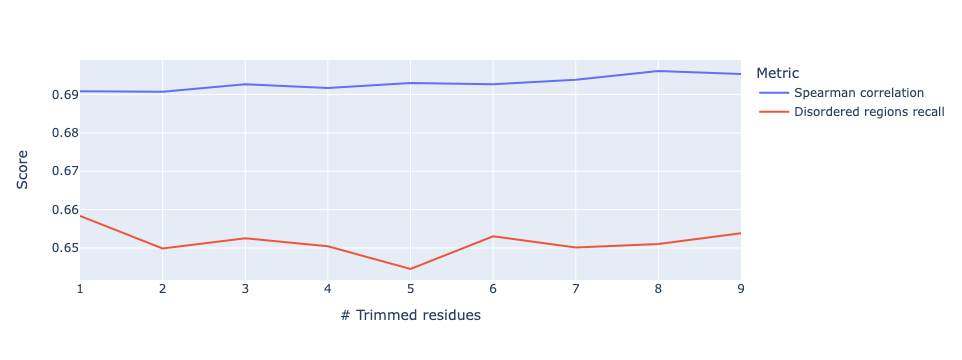

In [39]:
fig = px.line(df_trim_show, x='# Trimmed residues', y='Score', color='Metric')
fig.show()

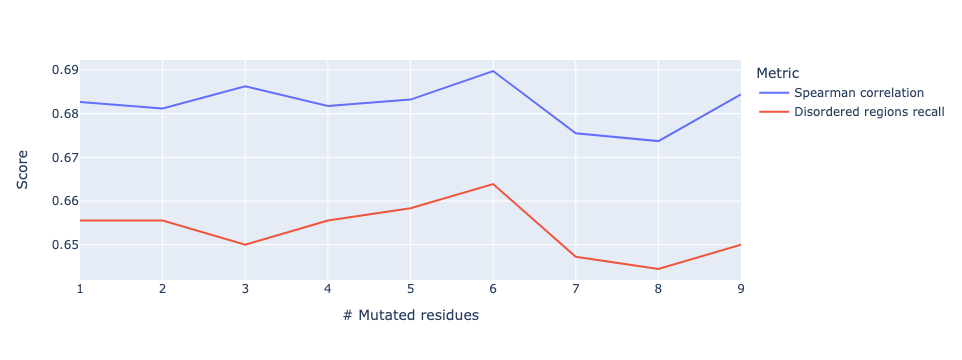

In [40]:
fig = px.line(df_rand_show, x='# Mutated residues', y='Score', color='Metric')
fig.show()

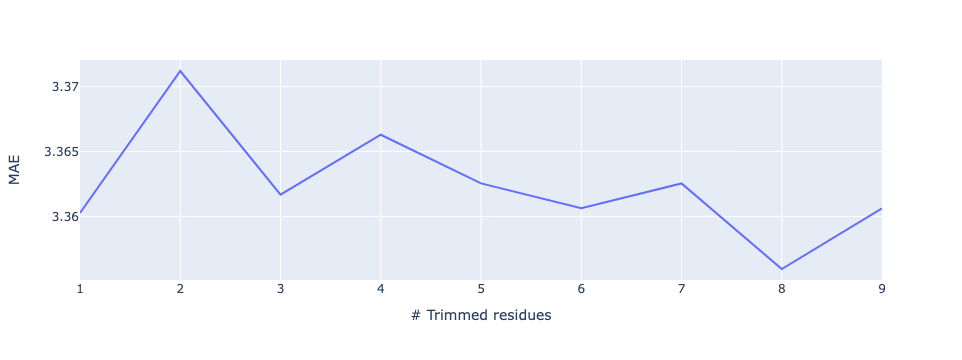

In [41]:
fig = px.line(df_trim_mae, x='# Trimmed residues', y='MAE')
fig.show()

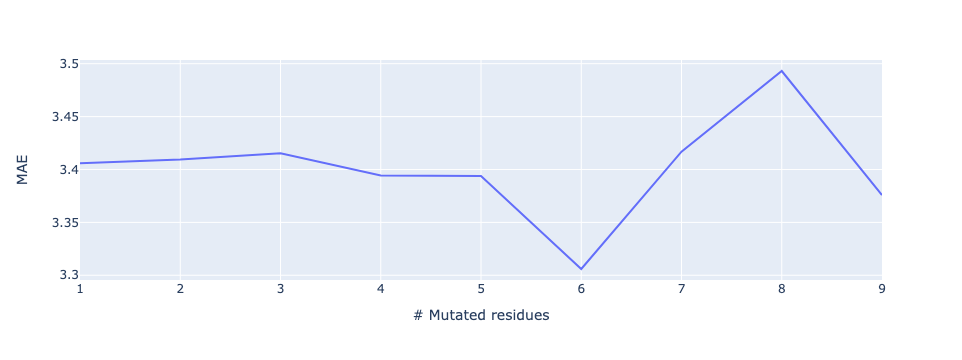

In [31]:
fig = px.line(df_rand_mae, x='# Mutated residues', y='MAE')
fig.show()